In [18]:
import pandas as pd
import pdb

# 1. Cargar los datos desde un archivo CSV (ajusta el nombre del archivo)
df = pd.read_csv("DATA_ORIGINAL/O3.csv")

df["FECHA"] = pd.to_datetime(df["FECHA"], format="%d/%m/%Y %H:%M", errors="coerce")


# 3. Reestructurar el DataFrame para que tenga dos columnas: 'NOMBRE_LOCALIDAD' y 'Ozono'
df_melted = df.melt(id_vars=["FECHA"], var_name="NOMBRE_LOCALIDAD", value_name="Ozono")

# 4. Crear un diccionario para normalizar los nombres de las localidades
mapa_localidades = {
    "BOLIVIA": "BOSA",
    "CARVAJAL": "KENNEDY",
    "CENTRO DE ALTO RENDIMIENTO": "CHAPINERO",
    "CIUDAD BOLIVAR": "CIUDAD BOLIVAR",
    "FONTIBON": "FONTIBON",
    "GUAYMARAL": "SUBA",
    "JAZMIN": "PUENTE ARANDA",
    "KENNEDY": "KENNEDY",
    "LAS FERIAS": "ENGATIVA",
    "MIN AMBIENTE": "SANTA FE",
    "PUENTE ARANDA": "PUENTE ARANDA",
    "SAN CRISTOBAL": "SAN CRISTOBAL",
    "SUBA": "SUBA",
    "TUNAL": "TUNJUELITO",
    "USAQUEN": "USAQUEN",
    "USME": "USME",
    "COLINA": "SUBA",
}

# 5. Aplicar la normalización de nombres
df_melted["NOMBRE_LOCALIDAD"] = df_melted["NOMBRE_LOCALIDAD"].replace(mapa_localidades)

# 6. Filtrar solo las localidades que están en el shapefile
localidades_shp = [
    "ANTONIO NARIÑO", "BARRIOS UNIDOS", "BOSA", "CANDELARIA", "CHAPINERO", "CIUDAD BOLIVAR",
    "ENGATIVA", "FONTIBON", "KENNEDY", "LOS MARTIRES", "PUENTE ARANDA", "RAFAEL URIBE URIBE",
    "SAN CRISTOBAL", "SANTA FE", "SUBA", "SUMAPAZ", "TEUSAQUILLO", "TUNJUELITO", "USAQUEN", "USME"
]

df_final = df_melted[df_melted["NOMBRE_LOCALIDAD"].isin(localidades_shp)]

# 7. Guardar el DataFrame transformado
df_final.to_csv("ozono_transformado.csv", index=False)

# Mostrar las primeras filas del DataFrame resultante
print(df_final.head())


                FECHA NOMBRE_LOCALIDAD  Ozono
0 2013-01-01 00:00:00             BOSA    NaN
1 2013-01-01 01:00:00             BOSA    NaN
2 2013-01-01 02:00:00             BOSA    NaN
3 2013-01-01 03:00:00             BOSA    NaN
4 2013-01-01 04:00:00             BOSA    NaN


In [25]:
import pandas as pd
import numpy as np

# 1. Cargar los datos

# 1. Cargar los datos desde un archivo CSV (ajusta el nombre del archivo)
df = pd.read_csv("ozono_transformado.csv")

df["FECHA"] = pd.to_datetime(df["FECHA"])

# 2. Rellenar valores NaN usando interpolación lineal por localidad
df["Ozono"] = df["Ozono"].replace([0, 9999], np.nan)
df["Ozono"] = df.groupby("NOMBRE_LOCALIDAD")["Ozono"].transform(lambda x: x.interpolate())

# 3. Función para calcular el valor diario máximo en un promedio móvil de 8 horas
def time_means(df):
    df = df.sort_values(["NOMBRE_LOCALIDAD", "FECHA"])  # Ordenar por localidad y tiempo
    df = df.set_index("FECHA")  # Establecer FECHA como índice
    df = df.groupby("NOMBRE_LOCALIDAD")["Ozono"].rolling("8H", min_periods=1).mean().reset_index()
    df = df.groupby(["NOMBRE_LOCALIDAD", df["FECHA"].dt.date])["Ozono"].max().reset_index()
    df["FECHA"] = pd.to_datetime(df["FECHA"])  # Convertir FECHA a datetime nuevamente
    return df

# 4. Función para calcular tendencias mensuales
def mon_tend(df):
    df = df.sort_values(["NOMBRE_LOCALIDAD", "FECHA"])  # Asegurar orden correcto
    df = df.set_index("FECHA")
    monmean = df.groupby("NOMBRE_LOCALIDAD").resample("M")["Ozono"].mean().reset_index()
    monstd = df.groupby("NOMBRE_LOCALIDAD").resample("M")["Ozono"].std().reset_index()
    return monmean, monstd

# 5. Aplicar las funciones corregidas
df_max_8h = time_means(df)
df_monmean, df_monstd = mon_tend(df)

# 6. Guardar los resultados
df_max_8h.to_csv("ozono_max_8h.csv", index=False)
df_monmean.to_csv("ozono_mensual_mean.csv", index=False)
df_monstd.to_csv("ozono_mensual_std.csv", index=False)

# Mostrar los primeros resultados
print(df_max_8h.head())
print(df_monmean.head())
print(df_monstd.head())


  NOMBRE_LOCALIDAD      FECHA  Ozono
0             BOSA 2013-01-01    NaN
1             BOSA 2013-01-02    NaN
2             BOSA 2013-01-03    NaN
3             BOSA 2013-01-04    NaN
4             BOSA 2013-01-05    NaN
  NOMBRE_LOCALIDAD      FECHA  Ozono
0             BOSA 2013-01-31    NaN
1             BOSA 2013-02-28    NaN
2             BOSA 2013-03-31    NaN
3             BOSA 2013-04-30    NaN
4             BOSA 2013-05-31    NaN
  NOMBRE_LOCALIDAD      FECHA  Ozono
0             BOSA 2013-01-31    NaN
1             BOSA 2013-02-28    NaN
2             BOSA 2013-03-31    NaN
3             BOSA 2013-04-30    NaN
4             BOSA 2013-05-31    NaN


**PROMEDIOS PARA CALCULOS**

In [27]:
def imputar(archivo_csv):
    print(''); print('Procesando', archivo_csv)
    data            = pd.read_csv('DATA_ORIGINAL/' + archivo_csv, index_col = 0, parse_dates=True)
    data_nan        = data.fillna(999)
    promedios_horas = data.groupby(data.index.strftime('%H')).mean()

    suma = 0
    for name_estacion in data.columns:
        suma += 1; progress = int(suma/len(data.columns) * 100)
        sys.stdout.write('\r')
        sys.stdout.write('[%-20s] %d%%' % ('=' * progress, progress))
        sys.stdout.flush()

        for i in np.arange(0,len(data_nan[name_estacion]),1):
            dato = data_nan[name_estacion][i]

            if dato == 999:
                hora = int(data_nan[name_estacion].index[i].hour)
                data_nan[name_estacion][i] = promedios_horas[name_estacion][hora]
    # QUITAR esta linea para tener todas las estaciones
    #data_nan = pd.DataFrame(data_nan.mean(axis=1)).rename(columns={0: 'MEAN'})
    data_nan.to_csv('SALIDAS/llenado_' + archivo_csv)

In [28]:
# Asegurar que FECHA esté en formato datetime y sin valores NaT
df["FECHA"] = pd.to_datetime(df["FECHA"], errors="coerce")
df = df.dropna(subset=["FECHA"])

# Rellenar valores NaN usando interpolación lineal por localidad
df["Ozono"] = df["Ozono"].replace([0, 9999], np.nan)
df["Ozono"] = df.groupby("NOMBRE_LOCALIDAD")["Ozono"].transform(lambda x: x.interpolate())

# Función para calcular el valor diario máximo en un promedio móvil de 8 horas
def time_means(df):
    df = df.sort_values(["NOMBRE_LOCALIDAD", "FECHA"])
    df = df.set_index("FECHA")
    df = df.groupby("NOMBRE_LOCALIDAD")["Ozono"].rolling("8H", min_periods=1).mean().reset_index()
    df = df.groupby(["NOMBRE_LOCALIDAD", df["FECHA"].dt.date])["Ozono"].max().reset_index()
    df["FECHA"] = pd.to_datetime(df["FECHA"])
    return df

# Función para calcular tendencias mensuales
def mon_tend(df):
    df = df.sort_values(["NOMBRE_LOCALIDAD", "FECHA"])
    df = df.set_index("FECHA")
    monmean = df.groupby("NOMBRE_LOCALIDAD").resample("M")["Ozono"].mean().reset_index()
    monstd = df.groupby("NOMBRE_LOCALIDAD").resample("M")["Ozono"].std().reset_index()
    return monmean, monstd

# Aplicar funciones
df_max_8h = time_means(df)
df_monmean, df_monstd = mon_tend(df)

# Guardar resultados
df_max_8h.to_csv("ozono_max_8h.csv", index=False)
df_monmean.to_csv("ozono_mensual_mean.csv", index=False)
df_monstd.to_csv("ozono_mensual_std.csv", index=False)

# Mostrar resultados
print(df_max_8h.head())
print(df_monmean.head())
print(df_monstd.head())

  NOMBRE_LOCALIDAD      FECHA  Ozono
0             BOSA 2013-01-01    NaN
1             BOSA 2013-01-02    NaN
2             BOSA 2013-01-03    NaN
3             BOSA 2013-01-04    NaN
4             BOSA 2013-01-05    NaN
  NOMBRE_LOCALIDAD      FECHA  Ozono
0             BOSA 2013-01-31    NaN
1             BOSA 2013-02-28    NaN
2             BOSA 2013-03-31    NaN
3             BOSA 2013-04-30    NaN
4             BOSA 2013-05-31    NaN
  NOMBRE_LOCALIDAD      FECHA  Ozono
0             BOSA 2013-01-31    NaN
1             BOSA 2013-02-28    NaN
2             BOSA 2013-03-31    NaN
3             BOSA 2013-04-30    NaN
4             BOSA 2013-05-31    NaN


In [29]:
import pandas as pd

# Cargar datos mensuales
df = pd.read_csv("ozono_mensual_mean.csv")

# Convertir la columna FECHA a tipo datetime si no lo está
df["FECHA"] = pd.to_datetime(df["FECHA"])

# Extraer el año
df["AÑO"] = df["FECHA"].dt.year

# Agrupar por localidad y año, luego calcular el promedio anual
anual_mean = df.groupby(["NOMBRE_LOCALIDAD", "AÑO"])["Ozono"].mean().reset_index()

# Guardar el resultado en un nuevo archivo CSV
anual_mean.to_csv("anualmean_ozono.csv", index=False)

print("Archivo anual guardado: anualmean_temperatura.csv")


Archivo anual guardado: anualmean_temperatura.csv


GRAFICOS MAPA - OZONO

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_47072/1857954544.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


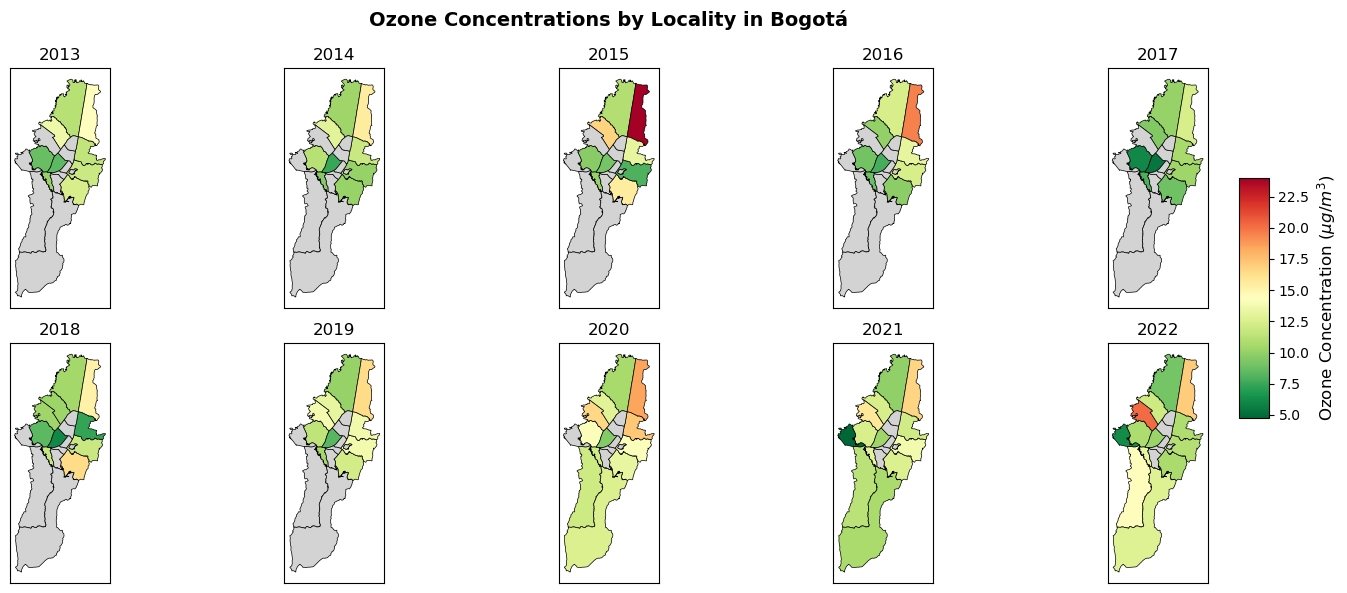

In [31]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar el shapefile de las localidades de Bogotá
shapefile_path = "poligonos-localidades.shp"
gdf = gpd.read_file(shapefile_path)

# 2. Cargar los datos de Ozono por localidad
ozone_data = pd.read_csv("ozono_mensual_mean.csv")

# 3. Convertir la columna de fecha a formato datetime y extraer el año
ozone_data["FECHA"] = pd.to_datetime(ozone_data["FECHA"])
ozone_data["YEAR"] = ozone_data["FECHA"].dt.year  # Extraer el año

# 4. Agrupar por localidad y año, calculando el promedio anual
ozone_data = ozone_data.groupby(["NOMBRE_LOCALIDAD", "YEAR"])["Ozono"].mean().reset_index()

# 5. Renombrar la columna del shapefile para que coincida con el CSV
gdf.rename(columns={"Nombre_de_l": "NOMBRE_LOCALIDAD"}, inplace=True)

# 6. Asegurar consistencia en los nombres de localidades
gdf["NOMBRE_LOCALIDAD"] = gdf["NOMBRE_LOCALIDAD"].str.upper().str.strip()
ozone_data["NOMBRE_LOCALIDAD"] = ozone_data["NOMBRE_LOCALIDAD"].str.upper().str.strip()

# 7. Pivotear la tabla para que los años sean columnas
ozone_pivot = ozone_data.pivot(index="NOMBRE_LOCALIDAD", columns="YEAR", values="Ozono").reset_index()

# 8. Unir los datos de Ozono con el shapefile
gdf = gdf.merge(ozone_pivot, on="NOMBRE_LOCALIDAD", how="left")

# 🔹 **Filtrar para eliminar Sumapaz**
gdf = gdf[gdf["NOMBRE_LOCALIDAD"] != "SUMAPAZ"]

# 9. Obtener los años disponibles en los datos
years = sorted([year for year in range(2013, 2023) if year in gdf.columns])
num_years = len(years)

# 10. Definir valores mínimo y máximo dinámicos para la escala de color
vmin = gdf[years].min().min()  # Mínimo global de Ozono
vmax = gdf[years].max().max()  # Máximo global de Ozono

# 11. Configurar subgráficos
cols = 5  # Número de columnas fijas
rows = -(-num_years // cols)  # Calcular filas redondeando hacia arriba

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))  # Ajustar tamaño
axes = axes.flatten()

cmap = sns.color_palette("RdYlGn_r", as_cmap=True)  # Mapa de color rojo-amarillo-verde (invertido)

for i, year in enumerate(years):
    ax = axes[i]

    # 12. Graficar el mapa con localidades sin datos en gris
    gdf.plot(column=year, cmap=cmap, linewidth=0.5, edgecolor='black',
             legend=False, ax=ax, vmin=vmin, vmax=vmax,
             missing_kwds={'color': 'lightgrey', 'label': 'Localidad sin datos'})

    ax.set_title(str(year), fontsize=12)
    ax.set_xticks([])  # Quitar marcas en X
    ax.set_yticks([])  # Quitar marcas en Y

    # 13. Agregar meridianos y paralelos
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# 14. Eliminar los ejes vacíos
for j in range(num_years, len(axes)):
    fig.delaxes(axes[j])

# 15. Agregar la barra de color con etiqueta
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Posición de la barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r"Ozone Concentration ($\mu g/m^3$)", fontsize=12)

# 16. Mostrar el gráfico con título
plt.suptitle("Ozone Concentrations by Locality in Bogotá", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()



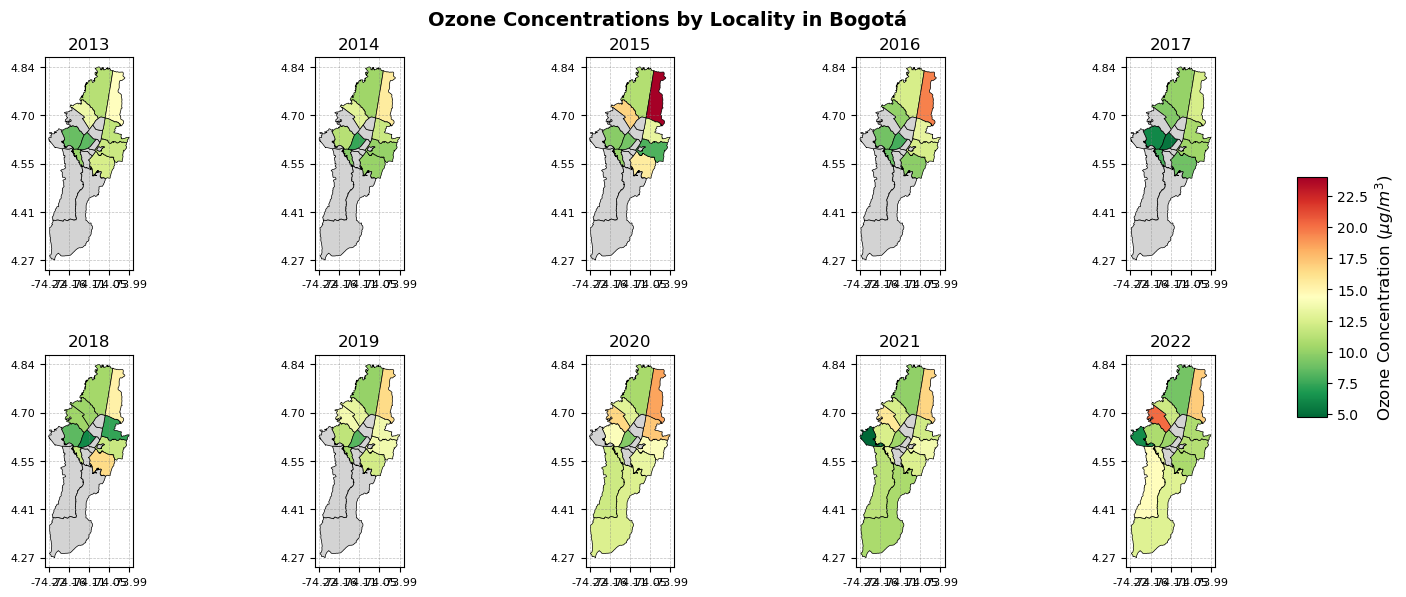

In [32]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Import for numerical operations

# 1. Cargar el shapefile de las localidades de Bogotá
shapefile_path = "poligonos-localidades.shp"
gdf = gpd.read_file(shapefile_path)

# 2. Cargar los datos de Ozono por localidad
ozone_data = pd.read_csv("ozono_mensual_mean.csv")

# 3. Convertir la columna de fecha a formato datetime y extraer el año
ozone_data["FECHA"] = pd.to_datetime(ozone_data["FECHA"])
ozone_data["YEAR"] = ozone_data["FECHA"].dt.year  # Extraer el año

# 4. Agrupar por localidad y año, calculando el promedio anual
ozone_data = ozone_data.groupby(["NOMBRE_LOCALIDAD", "YEAR"])["Ozono"].mean().reset_index()

# 5. Renombrar la columna del shapefile para que coincida con el CSV
gdf.rename(columns={"Nombre_de_l": "NOMBRE_LOCALIDAD"}, inplace=True)

# 6. Asegurar consistencia en los nombres de localidades
gdf["NOMBRE_LOCALIDAD"] = gdf["NOMBRE_LOCALIDAD"].str.upper().str.strip()
ozone_data["NOMBRE_LOCALIDAD"] = ozone_data["NOMBRE_LOCALIDAD"].str.upper().str.strip()

# 7. Pivotear la tabla para que los años sean columnas
ozone_pivot = ozone_data.pivot(index="NOMBRE_LOCALIDAD", columns="YEAR", values="Ozono").reset_index()

# 8. Unir los datos de Ozono con el shapefile
gdf = gdf.merge(ozone_pivot, on="NOMBRE_LOCALIDAD", how="left")

# 🔹 Filtrar para eliminar Sumapaz
gdf = gdf[gdf["NOMBRE_LOCALIDAD"] != "SUMAPAZ"]

# 9. Obtener los años disponibles en los datos
years = sorted([year for year in range(2013, 2023) if year in gdf.columns])
num_years = len(years)

# 10. Definir valores mínimo y máximo dinámicos para la escala de color
vmin = gdf[years].min().min()  # Mínimo global de Ozono
vmax = gdf[years].max().max()  # Máximo global de Ozono

# Calcular los límites totales para definir ticks de meridianos y paralelos
xmin, ymin, xmax, ymax = gdf.total_bounds
lon_ticks = np.linspace(xmin, xmax, num=5)
lat_ticks = np.linspace(ymin, ymax, num=5)

# 11. Configurar subgráficos
cols = 5  # Número de columnas fijas
rows = -(-num_years // cols)  # Calcular filas redondeando hacia arriba

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

cmap = sns.color_palette("RdYlGn_r", as_cmap=True)  # Mapa de color invertido

for i, year in enumerate(years):
    ax = axes[i]

    # 12. Graficar el mapa con localidades sin datos en gris
    gdf.plot(column=year, cmap=cmap, linewidth=0.5, edgecolor='black',
             legend=False, ax=ax, vmin=vmin, vmax=vmax,
             missing_kwds={'color': 'lightgrey', 'label': 'Localidad sin datos'})

    ax.set_title(str(year), fontsize=12)

    # 13. Agregar meridianos y paralelos con etiquetas
    ax.set_xticks(lon_ticks)
    ax.set_yticks(lat_ticks)
    ax.set_xticklabels([f'{tick:.2f}' for tick in lon_ticks], fontsize=8)
    ax.set_yticklabels([f'{tick:.2f}' for tick in lat_ticks], fontsize=8)

    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# 14. Eliminar los ejes vacíos de subplots no utilizados
for j in range(num_years, len(axes)):
    fig.delaxes(axes[j])

# Ajustar manualmente el layout para una distribución equidistante
fig.subplots_adjust(left=0.05, right=0.90, top=0.90, bottom=0.05, wspace=0.4, hspace=0.4)

# 15. Agregar la barra de color con etiqueta
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Posición de la barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r"Ozone Concentration ($\mu g/m^3$)", fontsize=12)

# 16. Mostrar el gráfico con título
plt.suptitle("Ozone Concentrations by Locality in Bogotá", fontsize=14, fontweight="bold")
plt.show()

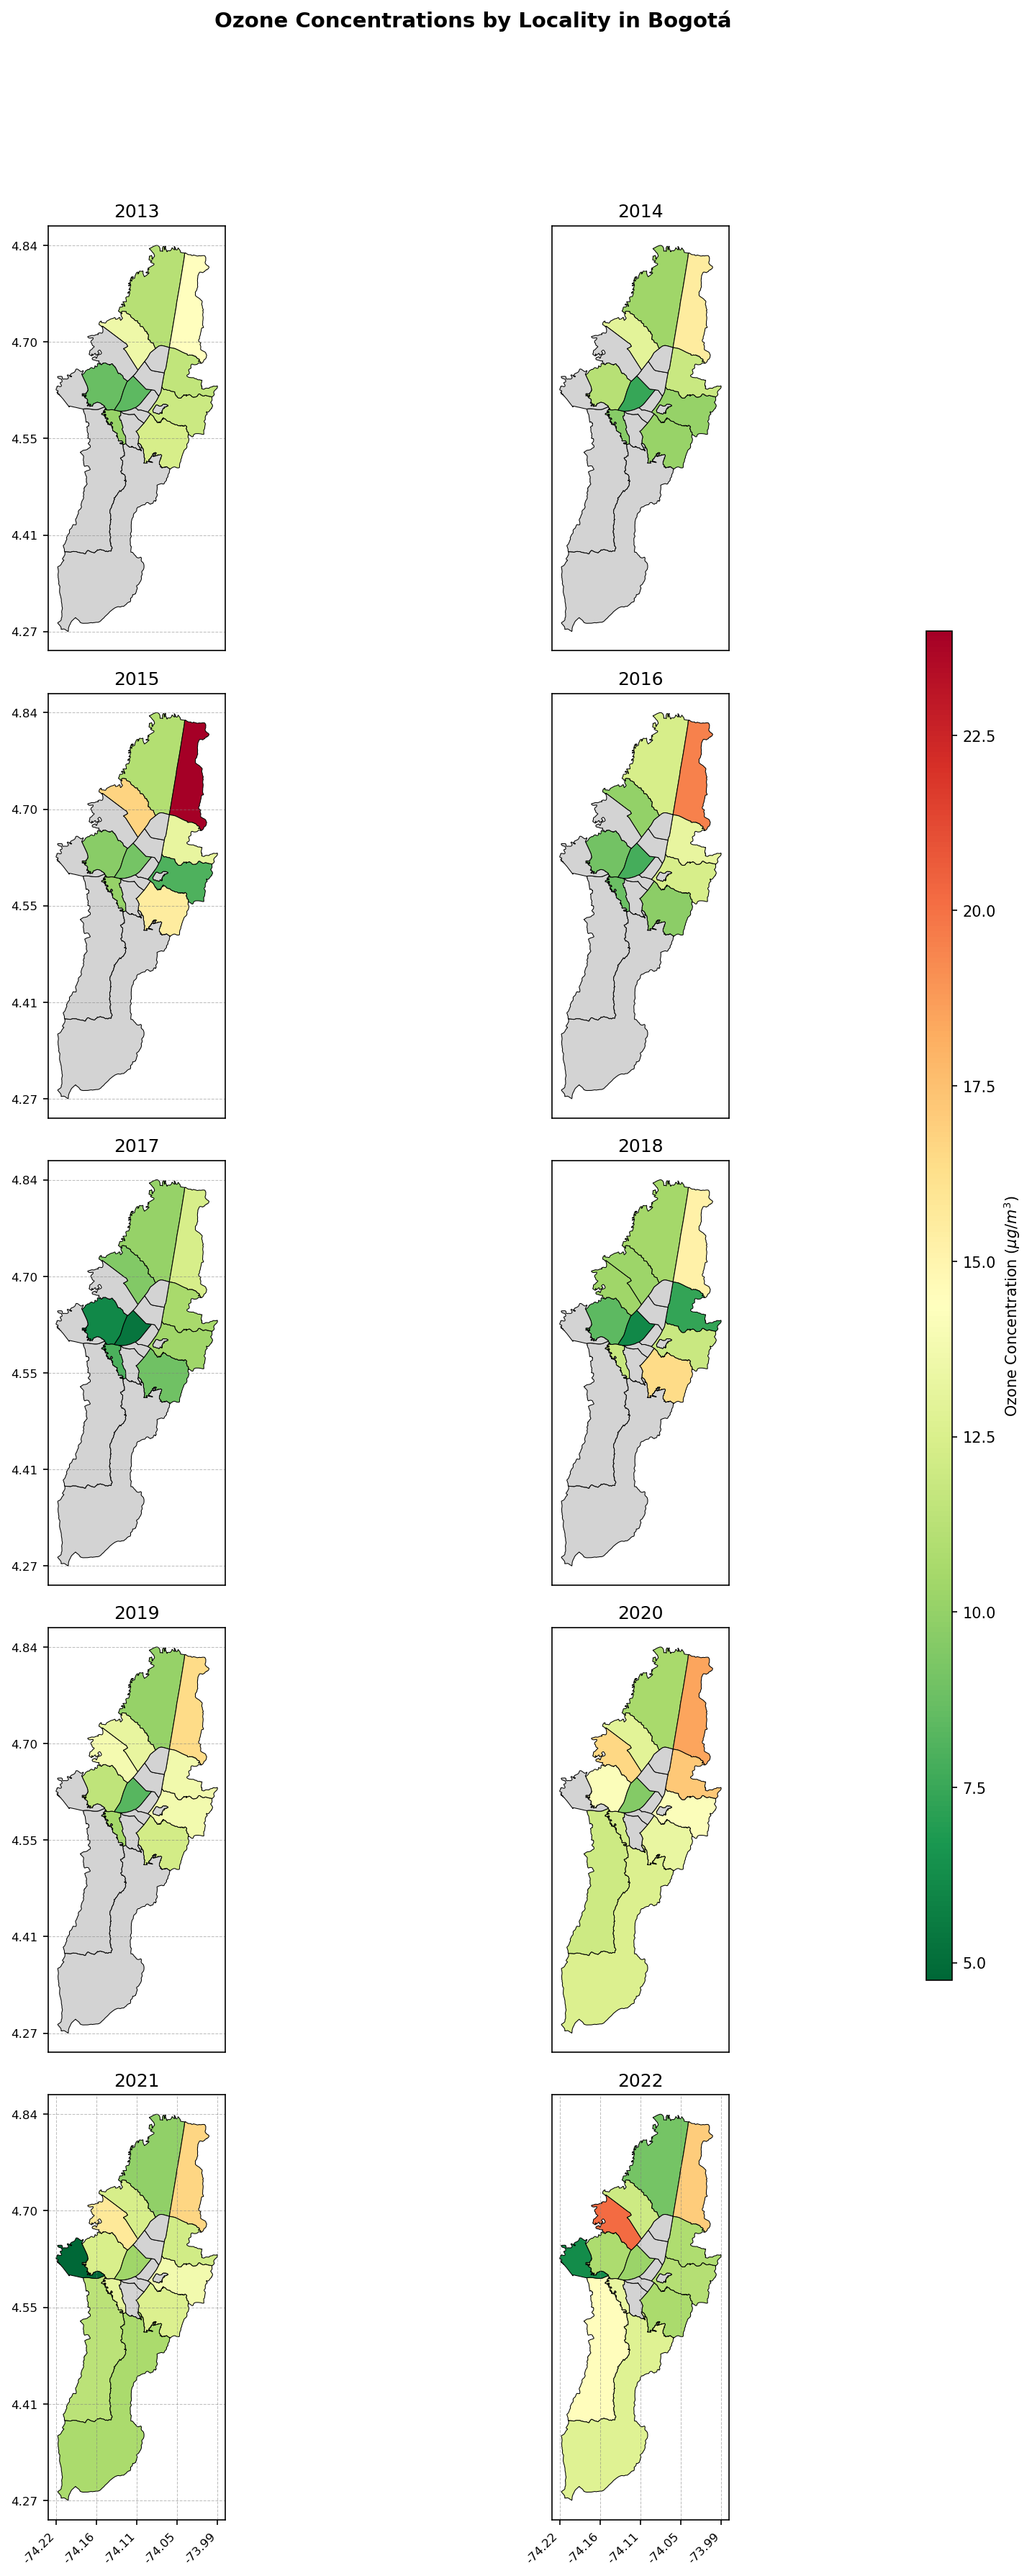

In [33]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Cargar el shapefile de las localidades de Bogotá
shapefile_path = "poligonos-localidades.shp"
gdf = gpd.read_file(shapefile_path)

# 2. Cargar los datos de Ozono por localidad
ozone_data = pd.read_csv("ozono_mensual_mean.csv")

# 3. Convertir la columna de fecha a formato datetime y extraer el año
ozone_data["FECHA"] = pd.to_datetime(ozone_data["FECHA"])
ozone_data["YEAR"] = ozone_data["FECHA"].dt.year  # Extraer el año

# 4. Agrupar por localidad y año, calculando el promedio anual
ozone_data = ozone_data.groupby(["NOMBRE_LOCALIDAD", "YEAR"])["Ozono"].mean().reset_index()

# 5. Renombrar la columna del shapefile para que coincida con el CSV
gdf.rename(columns={"Nombre_de_l": "NOMBRE_LOCALIDAD"}, inplace=True)

# 6. Asegurar consistencia en los nombres de localidades
gdf["NOMBRE_LOCALIDAD"] = gdf["NOMBRE_LOCALIDAD"].str.upper().str.strip()
ozone_data["NOMBRE_LOCALIDAD"] = ozone_data["NOMBRE_LOCALIDAD"].str.upper().str.strip()

# 7. Pivotear la tabla para que los años sean columnas
ozone_pivot = ozone_data.pivot(index="NOMBRE_LOCALIDAD", columns="YEAR", values="Ozono").reset_index()

# 8. Unir los datos de Ozono con el shapefile
gdf = gdf.merge(ozone_pivot, on="NOMBRE_LOCALIDAD", how="left")

# 🔹 Filtrar para eliminar Sumapaz
gdf = gdf[gdf["NOMBRE_LOCALIDAD"] != "SUMAPAZ"]

# 9. Obtener los años disponibles en los datos
years = sorted([year for year in range(2013, 2023) if year in gdf.columns])
num_years = len(years)

# 10. Definir valores mínimo y máximo dinámicos para la escala de color
vmin = gdf[years].min().min()
vmax = gdf[years].max().max()

# Calcular los límites totales para definir ticks de meridianos y paralelos
xmin, ymin, xmax, ymax = gdf.total_bounds
lon_ticks = np.linspace(xmin, xmax, num=5)
lat_ticks = np.linspace(ymin, ymax, num=5)

# 11. Configurar subgráficos con 2 columnas
cols = 2
rows = -(-num_years // cols)  # Redondear hacia arriba

# -- FIGURE & DPI --
# A larger figure size (in inches) + higher DPI = bigger maps on screen.
# For example, 12 inches wide × (rows*5) inches tall at 150 DPI.
fig, axes = plt.subplots(
    rows, cols,
    figsize=(12, rows * 5),  # Adjust height as needed
    dpi=150                  # Increase DPI for more actual pixels
)
axes = axes.flatten()

cmap = sns.color_palette("RdYlGn_r", as_cmap=True)

for i, year in enumerate(years):
    ax = axes[i]

    # 12. Graficar el mapa con localidades sin datos en gris
    gdf.plot(
        column=year, cmap=cmap, linewidth=0.5, edgecolor='black',
        legend=False, ax=ax, vmin=vmin, vmax=vmax,
        missing_kwds={'color': 'lightgrey', 'label': 'Localidad sin datos'}
    )

    # Mantener la forma geográfica real (sin distorsión)
    ax.set_aspect('equal')

    ax.set_title(str(year), fontsize=12)

    # 13. Mostrar paralelos (latitudes) sólo en la columna izquierda
    if i % cols == 0:  # Left column
        ax.set_yticks(lat_ticks)
        ax.set_yticklabels([f'{tick:.2f}' for tick in lat_ticks], fontsize=8)
    else:
        ax.set_yticks([])

    # 14. Mostrar meridianos (longitudes) sólo en la última fila
    if i // cols == rows - 1:  # Bottom row
        ax.set_xticks(lon_ticks)
        # Rotar etiquetas 45° para evitar sobreposición
        ax.set_xticklabels([f'{tick:.2f}' for tick in lon_ticks],
                           fontsize=8, rotation=45, ha='right')
    else:
        ax.set_xticks([])

    # Grid opcional
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Eliminar ejes vacíos si hay más subplots que años
for j in range(num_years, len(axes)):
    fig.delaxes(axes[j])

# 15. Ajustar layout para reducir espacios entre subplots
# wspace/hspace se definen como fracciones del tamaño del subplot
# Ajustar estos valores si aún ves demasiado espacio
fig.subplots_adjust(
    left=0.05, right=0.82, top=0.90, bottom=0.05,
    wspace=0.02,  # reduce espacio horizontal
    hspace=0.10   # reduce espacio vertical
)

# 16. Barra de color
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r"Ozone Concentration ($\mu g/m^3$)", fontsize=10)

# 17. Título global
plt.suptitle("Ozone Concentrations by Locality in Bogotá", fontsize=14, fontweight="bold")

plt.show()

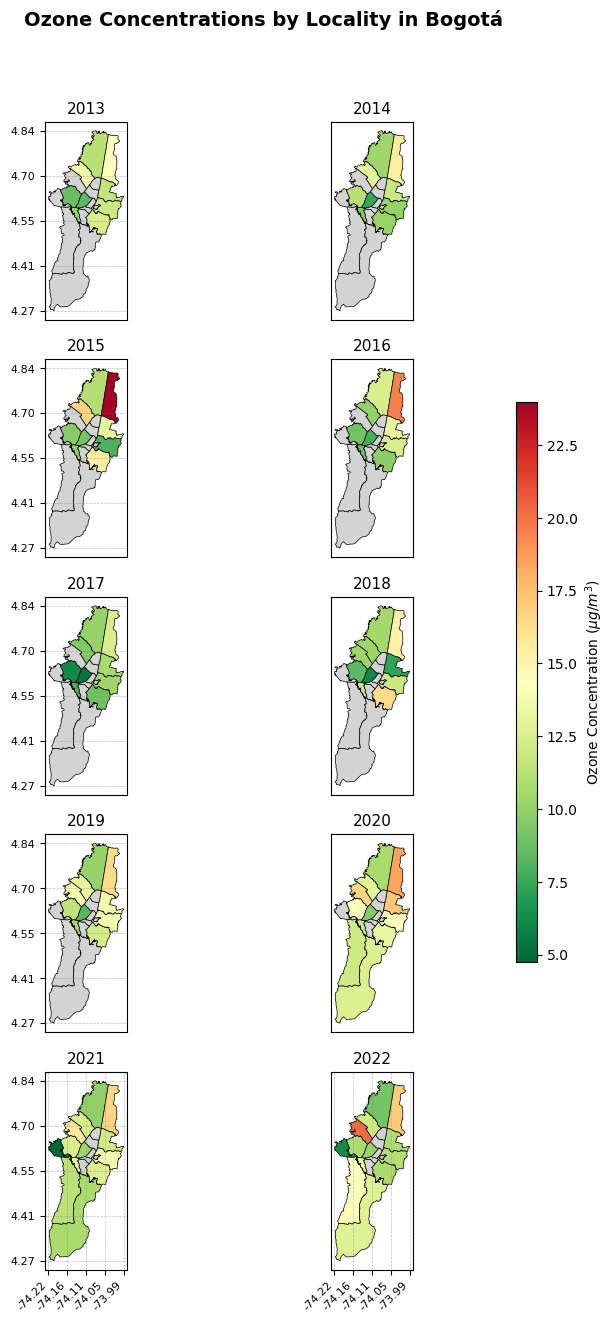

In [34]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Cargar el shapefile de las localidades de Bogotá
shapefile_path = "poligonos-localidades.shp"
gdf = gpd.read_file(shapefile_path)

# 2. Cargar los datos de Ozono por localidad
ozone_data = pd.read_csv("ozono_mensual_mean.csv")

# 3. Convertir la columna de fecha a formato datetime y extraer el año
ozone_data["FECHA"] = pd.to_datetime(ozone_data["FECHA"])
ozone_data["YEAR"] = ozone_data["FECHA"].dt.year  # Extraer el año

# 4. Agrupar por localidad y año, calculando el promedio anual
ozone_data = ozone_data.groupby(["NOMBRE_LOCALIDAD", "YEAR"])["Ozono"].mean().reset_index()

# 5. Renombrar la columna del shapefile para que coincida con el CSV
gdf.rename(columns={"Nombre_de_l": "NOMBRE_LOCALIDAD"}, inplace=True)

# 6. Asegurar consistencia en los nombres de localidades
gdf["NOMBRE_LOCALIDAD"] = gdf["NOMBRE_LOCALIDAD"].str.upper().str.strip()
ozone_data["NOMBRE_LOCALIDAD"] = ozone_data["NOMBRE_LOCALIDAD"].str.upper().str.strip()

# 7. Pivotear la tabla para que los años sean columnas
ozone_pivot = ozone_data.pivot(index="NOMBRE_LOCALIDAD", columns="YEAR", values="Ozono").reset_index()

# 8. Unir los datos de Ozono con el shapefile
gdf = gdf.merge(ozone_pivot, on="NOMBRE_LOCALIDAD", how="left")

# 🔹 Filtrar para eliminar Sumapaz
gdf = gdf[gdf["NOMBRE_LOCALIDAD"] != "SUMAPAZ"]

# 9. Obtener los años disponibles en los datos
years = sorted([year for year in range(2013, 2023) if year in gdf.columns])
num_years = len(years)

# 10. Definir valores mínimo y máximo dinámicos para la escala de color
vmin = gdf[years].min().min()
vmax = gdf[years].max().max()

# Calcular los límites totales para definir ticks de meridianos y paralelos
xmin, ymin, xmax, ymax = gdf.total_bounds
lon_ticks = np.linspace(xmin, xmax, num=5)
lat_ticks = np.linspace(ymin, ymax, num=5)

# 11. Configurar subgráficos con 2 columnas
cols = 2
rows = -(-num_years // cols)  # Redondear hacia arriba

# Ajusta la figura para ser más "vertical" que "horizontal"
# (puedes reducir/incrementar el 2.8 o 3 según tu preferencia).
fig, axes = plt.subplots(rows, cols, figsize=(7, rows * 2.8))
axes = axes.flatten()

cmap = sns.color_palette("RdYlGn_r", as_cmap=True)

for i, year in enumerate(years):
    ax = axes[i]

    # 12. Graficar el mapa
    gdf.plot(
        column=year, cmap=cmap, linewidth=0.5, edgecolor='black',
        legend=False, ax=ax, vmin=vmin, vmax=vmax,
        missing_kwds={'color': 'lightgrey', 'label': 'Localidad sin datos'}
    )

    # Mantener la forma original (sin estirar el mapa)
    ax.set_aspect('equal')

    ax.set_title(str(year), fontsize=11)

    # 13. Mostrar paralelos sólo en la columna izquierda
    if i % cols == 0:  # Left column
        ax.set_yticks(lat_ticks)
        ax.set_yticklabels([f'{tick:.2f}' for tick in lat_ticks], fontsize=8)
    else:
        ax.set_yticks([])

    # 14. Mostrar meridianos sólo en la última fila
    if i // cols == rows - 1:  # Bottom row
        ax.set_xticks(lon_ticks)
        # Rotar etiquetas 45° para evitar sobreposición
        ax.set_xticklabels([f'{tick:.2f}' for tick in lon_ticks],
                           fontsize=8, rotation=45, ha='right')
    else:
        ax.set_xticks([])

    # Opcional: Agregar grid para mayor claridad
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Eliminar ejes vacíos si num_years no llena todos los subplots
for j in range(num_years, len(axes)):
    fig.delaxes(axes[j])

# 15. Ajustar layout para reducir espacios:
# - left/right: bordes laterales de la figura
# - wspace/hspace: espacio horizontal/vertical entre subplots
fig.subplots_adjust(left=0.06, right=0.84, top=0.90, bottom=0.08,
                    wspace=0.10, hspace=0.20)

# 16. Agregar la barra de color
cbar_ax = fig.add_axes([0.86, 0.30, 0.03, 0.40])  # Ajusta según convenga
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r"Ozone Concentration ($\mu g/m^3$)", fontsize=10)

# 17. Título global
plt.suptitle("Ozone Concentrations by Locality in Bogotá", fontsize=14, fontweight="bold")

plt.show()

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_47072/594279018.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


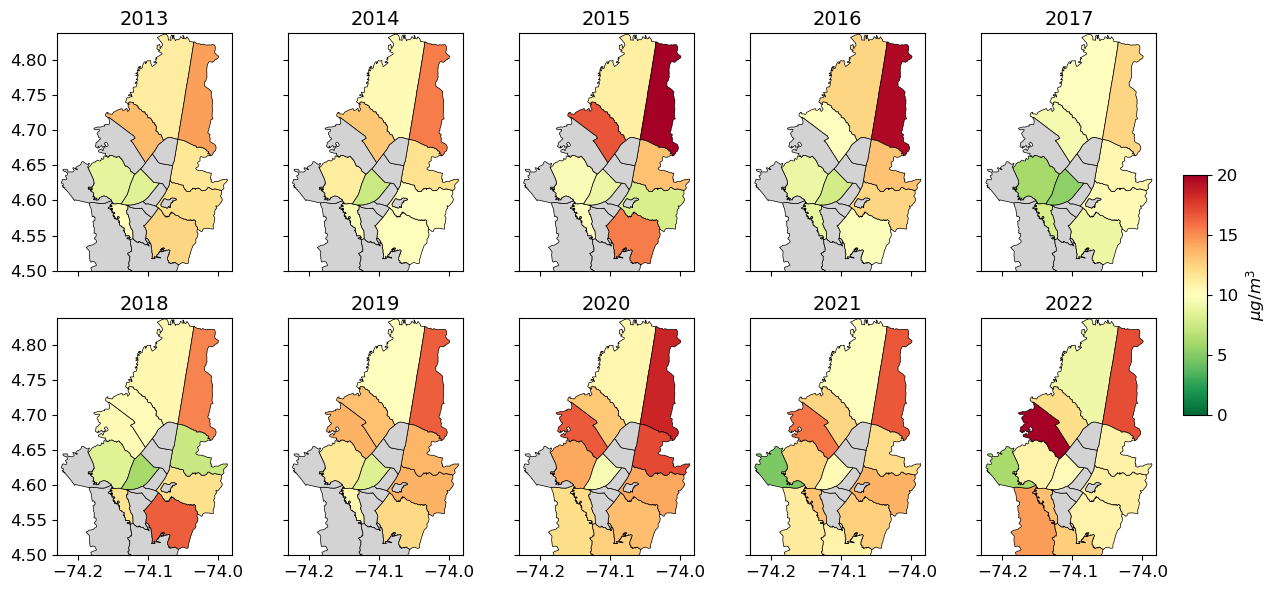

In [58]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar el shapefile de las localidades de Bogotá
shapefile_path = "poligonos-localidades.shp"
gdf = gpd.read_file(shapefile_path)

# 2. Cargar los datos de Ozono por localidad
ozone_data = pd.read_csv("ozono_mensual_mean.csv")

# 3. Convertir la columna de fecha a formato datetime y extraer el año
ozone_data["FECHA"] = pd.to_datetime(ozone_data["FECHA"])  # Asegurar que es formato fecha
ozone_data["YEAR"] = ozone_data["FECHA"].dt.year  # Extraer el año

# 4. Agrupar por localidad y año, calculando el promedio anual
ozone_data = ozone_data.groupby(["NOMBRE_LOCALIDAD", "YEAR"])["Ozono"].mean().reset_index()

# 5. Renombrar la columna del shapefile para que coincida con el CSV
gdf.rename(columns={"Nombre_de_l": "NOMBRE_LOCALIDAD"}, inplace=True)

# 6. Asegurar consistencia en los nombres de localidades
gdf["NOMBRE_LOCALIDAD"] = gdf["NOMBRE_LOCALIDAD"].str.upper().str.strip()
ozone_data["NOMBRE_LOCALIDAD"] = ozone_data["NOMBRE_LOCALIDAD"].str.upper().str.strip()

# 7. Pivotear la tabla para que los años sean columnas
ozone_pivot = ozone_data.pivot(index="NOMBRE_LOCALIDAD", columns="YEAR", values="Ozono").reset_index()

# 8. Unir los datos de Ozono con el shapefile
gdf = gdf.merge(ozone_pivot, on="NOMBRE_LOCALIDAD", how="left")

# 9. Obtener los años disponibles en los datos
years = sorted([year for year in range(2013, 2023) if year in gdf.columns])
num_years = len(years)

# 10. Definir la cantidad de filas y columnas del subplot (optimizado)
cols = 5  # Número de columnas fijas
rows = -(-num_years // cols)  # Calcular filas redondeando hacia arriba

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3))  # Ajustar tamaño
axes = axes.flatten()
lon_min, lon_max = -74.23, -73.98 # Rango de longitudes (meridianos)
lat_min, lat_max = 4.5, 4.838    # Rango de latitudes (paralelos)

cmap = sns.color_palette("RdYlGn_r", as_cmap=True)  # Mapa de color rojo-amarillo-verde (invertido)

for i, year in enumerate(years):
    ax = axes[i]
    row = i // cols
    col = i % cols

    gdf.plot(column=year, cmap=cmap, linewidth=0.5, edgecolor='black',
             legend=False, ax=ax, vmin=0, vmax=20,
             missing_kwds={'color': 'lightgrey'})

    ax.set_title(str(year), fontsize=14)
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.tick_params(axis='both', labelsize=12)

    # Show y-ticks only in the first column
    if col != 0:
        ax.set_yticklabels([])
        ax.set_ylabel("")

    # Show x-ticks only in the last row
    if row != rows - 1:
        ax.set_xticklabels([])
        ax.set_xlabel("")

# 11. Eliminar los ejes vacíos
for j in range(num_years, len(axes)):
    fig.delaxes(axes[j])

# 12. Agregar la barra de color
cbar_ax = fig.add_axes([0.99, 0.3, 0.02, 0.4])  # Posición de la barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=20))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r"$\mu g/m^3$", fontsize=12)
cbar.ax.tick_params(labelsize=12)

# 13. Mostrar el gráfico
#plt.suptitle("Estimaciones de Ozono por Localidad en Bogotá (2008-2021)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

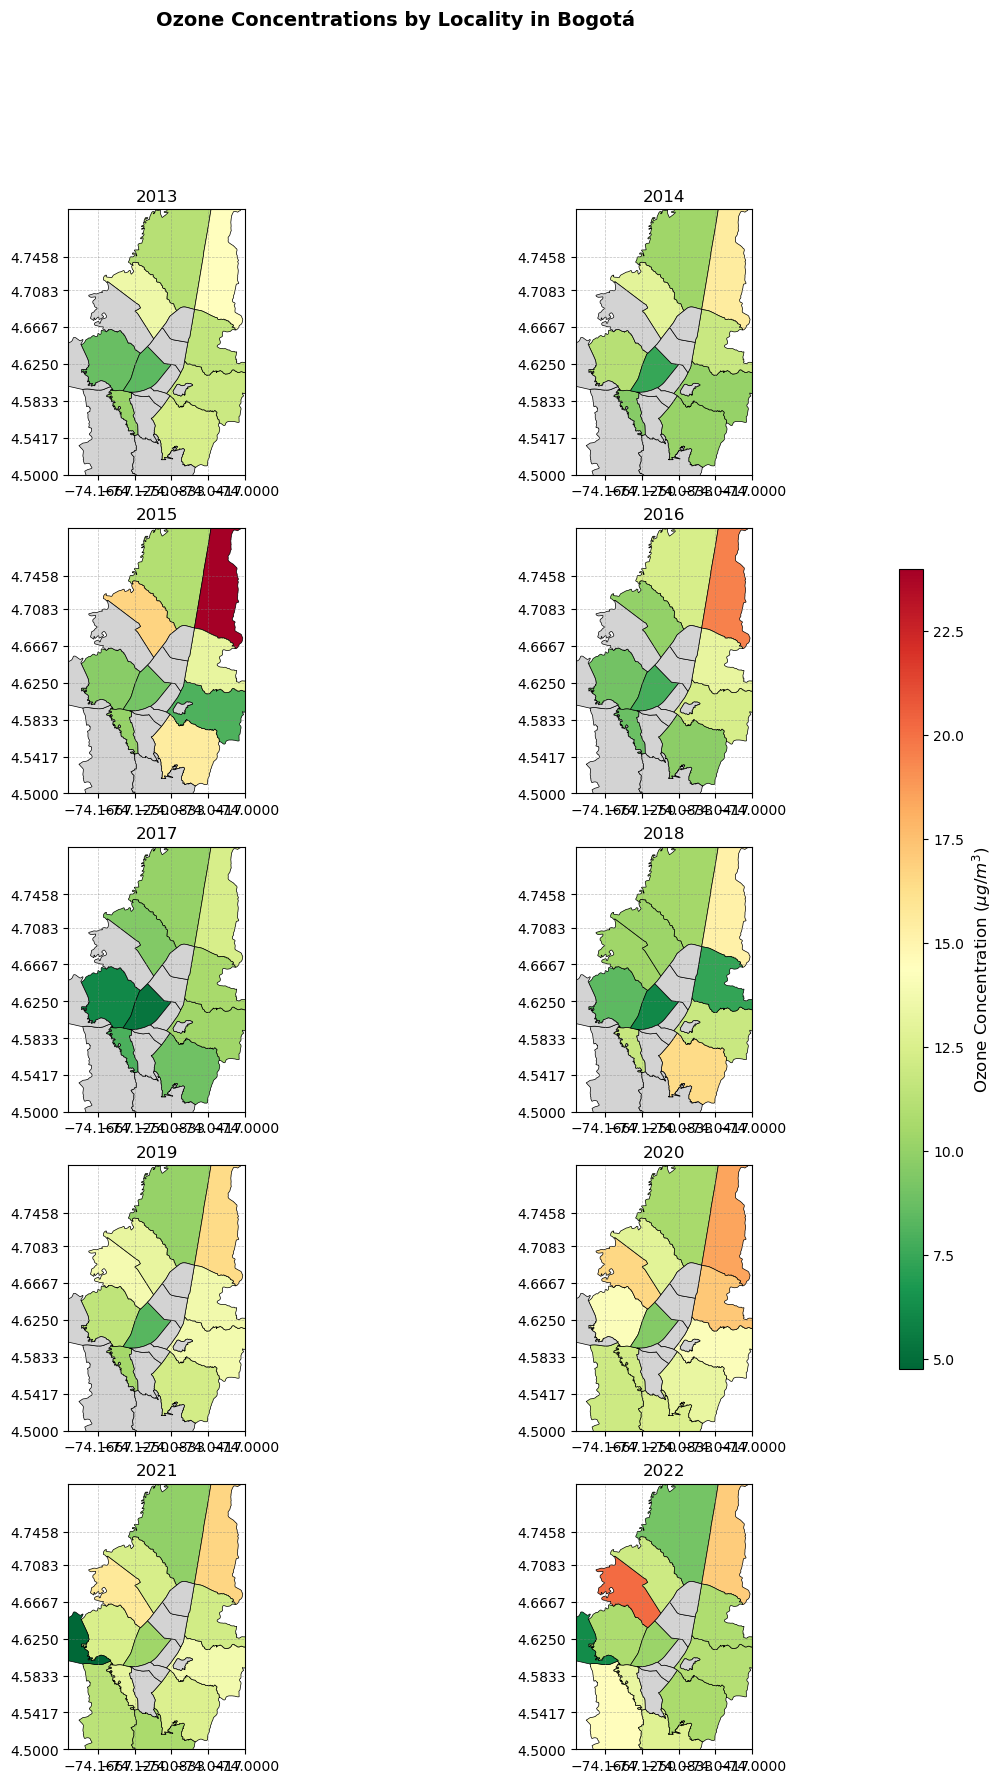

In [36]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar el shapefile de las localidades de Bogotá
shapefile_path = "poligonos-localidades.shp"
gdf = gpd.read_file(shapefile_path)

# 2. Cargar los datos de Ozono por localidad
ozone_data = pd.read_csv("ozono_mensual_mean.csv")

# 3. Convertir la columna de fecha a formato datetime y extraer el año
ozone_data["FECHA"] = pd.to_datetime(ozone_data["FECHA"])
ozone_data["YEAR"] = ozone_data["FECHA"].dt.year  # Extraer el año

# 4. Agrupar por localidad y año, calculando el promedio anual
ozone_data = ozone_data.groupby(["NOMBRE_LOCALIDAD", "YEAR"])["Ozono"].mean().reset_index()

# 5. Renombrar la columna del shapefile para que coincida con el CSV
gdf.rename(columns={"Nombre_de_l": "NOMBRE_LOCALIDAD"}, inplace=True)

# 6. Asegurar consistencia en los nombres de localidades
gdf["NOMBRE_LOCALIDAD"] = gdf["NOMBRE_LOCALIDAD"].str.upper().str.strip()
ozone_data["NOMBRE_LOCALIDAD"] = ozone_data["NOMBRE_LOCALIDAD"].str.upper().str.strip()

# 7. Pivotear la tabla para que los años sean columnas
ozone_pivot = ozone_data.pivot(index="NOMBRE_LOCALIDAD", columns="YEAR", values="Ozono").reset_index()

# 8. Unir los datos de Ozono con el shapefile
gdf = gdf.merge(ozone_pivot, on="NOMBRE_LOCALIDAD", how="left")

# 🔹 **Filtrar para eliminar Sumapaz**
gdf = gdf[gdf["NOMBRE_LOCALIDAD"] != "SUMAPAZ"]

# 9. Verificar y transformar la proyección a WGS 84 (EPSG:4326)
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)
else:
    gdf = gdf.to_crs(epsg=4326)

# 10. Obtener los años disponibles en los datos
years = sorted([year for year in range(2013, 2023) if year in gdf.columns])
num_years = len(years)

# 11. Definir valores mínimo y máximo dinámicos para la escala de color
vmin = gdf[years].min().min()  # Mínimo global de Ozono
vmax = gdf[years].max().max()  # Máximo global de Ozono

# 12. Configurar subgráficos con 2 columnas y 5 filas
cols = 2
rows = 5
fig, axes = plt.subplots(rows, cols, figsize=(12, 20))  # Ajustar tamaño de figura
axes = axes.flatten()

cmap = sns.color_palette("RdYlGn_r", as_cmap=True)  # Mapa de color rojo-amarillo-verde (invertido)

# 13. Definir los límites de Bogotá para las coordenadas de referencia
lon_min, lon_max = -74.2, -74.0  # Rango de longitudes (meridianos)
lat_min, lat_max = 4.5, 4.8      # Rango de latitudes (paralelos)

for i, year in enumerate(years):
    ax = axes[i]

    # 14. Graficar el mapa con localidades sin datos en gris
    gdf.plot(column=year, cmap=cmap, linewidth=0.5, edgecolor='black',
             legend=False, ax=ax, vmin=vmin, vmax=vmax,
             missing_kwds={'color': 'lightgrey', 'label': 'Localidad sin datos'})

    ax.set_title(str(year), fontsize=12)

    # 15. Agregar meridianos y paralelos
    ax.set_xticks([-74.2083, -74.1667, -74.1250, -74.0833, -74.0417, -74.0000])  # Meridianos principales
    ax.set_yticks([4.7458, 4.7083, 4.6667, 4.6250, 4.5833, 4.5417, 4.5000])   # Paralelos principales

    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# 16. Eliminar los ejes vacíos si hay menos de 10 años
for j in range(num_years, len(axes)):
    fig.delaxes(axes[j])

# 17. Agregar la barra de color con etiqueta
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Posición de la barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r"Ozone Concentration ($\mu g/m^3$)", fontsize=12)


# 19. Mostrar el gráfico con título
plt.suptitle("Ozone Concentrations by Locality in Bogotá", fontsize=14, fontweight="bold")
plt.show()


In [2]:
print(localidades.crs)

NameError: name 'localidades' is not defined

In [3]:
ozone_data

NameError: name 'ozone_data' is not defined